# Expected Performance Tests

In this notebook, I will be focusing on understanding and using a ResNet.

In order to ascertain the expected performance of the (later developed) CNN, I will be using the aforementioned ResNet for classification on the raw dataset. This will allow for a fair comparison/tradeoff between understanding if my developed model is under/over performing.

In other words, the transfer learning results will be used as a performance reference.

## Why ResNet?

### Concept

The concept of a Residual Network was conceived when dealing with the vanishing gradient problem related to Deep Neural Networks, an issue that led to inneficient/irrelevant weight updates, significantly increasing training time and simmultaneous performance degradation.

ResNets represent a type of architecture capable of learning **Residual Functions** instead of attempting to perfect full transformations, which allows for implementation of deeper networks while potentially avoiding exploding/vanishing gradients. 

### Learning
 
Instead of attempting to learn the function that transforms the inputs into outputs, a ResNet learns the residual, which represents the difference between te input and output. Essentially, it identifies small transformations for the input, which is usually much easier to learn, as a residual represents an approximation of the actual function.

Choosing the simplest, most shallow version of ResNet allows for a good starting point of expectd performance, as it will attempt to learn approximations of transformations for the DICOM data in the numpy arrays.

### Architecture


<div style="width: 70%; margin: 0 auto; text-align: center;">
    <img src="../z_imgs/ResNet-18-Architecture.png" alt="Hounsfield Units">
</div>


### Implementation

I will start by importing all necessary libraries, as well as the model itself:

In [3]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os


# -----------  ResNet

# Core library
import torch

# Essentials for development
import torch.nn as nn
import torchvision.models as models

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

In [27]:
# Loads the model
resnet18_example = models.resnet18(pretrained=True)

c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hasht\anaconda3\envs\fibrosis\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The original ResNet18 was designed for ImageNet, which has 1000 possible classes. Since our problem consists of binary classification, the last layer needs the following modification:

In [28]:
num_ftrs = resnet18_example.fc.in_features
resnet18_example.fc = nn.Linear(num_ftrs, 2)  

In [29]:
# Resizing numpy arrays
transform = transforms.Resize((224, 224))

In order to obtain valid results, the train test split must be done following the recommended data division. Every slice ID starting with "SerieCT" is to be used as a test/validation split.

In [30]:
# Loads the dataframe
# df_fibrosis = pd.read_pickle(r'X:\\RafaelAndre\\pickle_jar_local\\fibrosis_data.pkl')
df_fibrosis = pd.read_pickle(r'..\..\\fibrosis_data.pkl')

#df_fibrosis = pd.read_pickle(r'D:\Rafa\A1Uni\2semestre\Estágio\fibrosis_data.pkl')

In [31]:
df_fibrosis.head()

,SliceID,SliceData,Class
0,101__CT-0002-0001,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,101__CT-0002-0002,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,101__CT-0002-0003,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,101__CT-0002-0004,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
4,101__CT-0002-0005,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0


## From Dataframe to Dataset

Torch expects a Dataset instead of a Dataframe. In order to avoid complex transformations, I will be creating a `Dataset` class based on the previously defined df_fibrosis Dataframe, capable of reading the .np arrays as content.

In this case, we will have a `csv` file containing every ID and respective label (**annotations_file**) as well as a directory containing data pertaining to the DICOM slice images (**img_dir**). 

In [32]:
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


Since ResNet has been trained to use only RGB images and DICOM images are in grayscale, I have chosen to [implement this approach](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images):

"There is an easy way, though, which you can make your model work with grayscale images. You just need to make the image to appear to be RGB. The easiest way to do so is to repeat the image array 3 times on a new dimension. Because you will have the same image over all 3 channels, the performance of the model should be the same as it was on RGB images.

In numpy this can be easily done like this:"

```py
print(grayscale_batch.shape)  # (64, 224, 224)
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)
print(rgb_batch.shape)  # (64, 224, 224, 3)
```

In PyTorch, this can be done like so:

```python
transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
```

 - **Input shape**: The input `x` is a single-channel (grayscale) image of shape `(1, H, W)` (where `H` is the height and `W` is the width of the image).
 - **`x.repeat(3, 1, 1)`**: This repeats the grayscale image along the first axis (the channel axis) three times. The resulting shape is `(3, H, W)`, which means that the image now appears to have three channels, one for each of Red, Green, and Blue. **Each of these channels contains the same pixel values as the original grayscale image.**

### Data Integrity
This approach does not alter the original pixel values in the image. It simply duplicates the grayscale image across all three channels. The integrity of the data is preserved because no new information is added to the image—each of the three channels contains the same grayscale values.

In [33]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds random set of augmentations
        if self.albumentations:
            augmented = self.albumentations(image=image)
            image = augmented['image']

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

Due to the nature of the previously defined train-test split, there should be not one but two dataset instances (least complex way of defining this):

In [34]:
# Create flag to identify "HRCT_Pilot" cases
test_flag = df_annotations.iloc[:, 0].str.contains("HRCT_Pilot", na=False)  

# Separate into two dataframes 
train_data = df_annotations[~test_flag]  
test_data = df_annotations[test_flag]

# Generate csv files
train_data.to_csv("train_dataframe.csv", index=False)
test_data.to_csv("test_dataframe.csv", index=False)

In [35]:
# Paths
#img_dir = r'D:\Rafa\A1Uni\2semestre\Estágio\np_ROI_data'  # CSV with image filenames & labels
img_dir = r"..\..\np_ROI_data"
annotations_file_train = "train_dataframe.csv"
annotations_file_test = "test_dataframe.csv"


# Transformations 
transform = transforms.Compose([
    # shear, translate, rotate, random(gauss_noise, gauss_blur)
    # possível resize (fibrose pode não precisar de 512)
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

Let's check if the contents changed to tensor and represent an image of size ((224,224)) with 1 grayscale dimension (adapted to 3 RGB):

In [36]:
def checkShape(train_dataset, dataset_size=len(train_dataset)):

    # Random choice of Slice
    idx = random.choice(range(dataset_size))

    # Identifies name of file corresponding to the first line of the train dataset
    slice_id = train_dataset.img_labels.iloc[idx, 0]  
    print(f"SliceID at index {idx}: {slice_id}")

    # Pulls first index of value of pandas series element with corresponding id -> 
    # -> gets np array and displays original shape
    print("\nOriginal np.array shape:")
    print((df_fibrosis["SliceData"][df_fibrosis["SliceID"] == slice_id[:-4]]).values[0].shape)

    print("----------------------")

    # Pulls "image" value from the (image, label) pair in the train dataset -> 
    # -> gets torch tensor and displays new shape
    print("\nTransformed tensor shape:")
    print(train_dataset[idx][0].shape)

In [37]:
checkShape(train_dataset)

SliceID at index 476: 128__CT-0007-0051.npy

Original np.array shape:
(512, 512)
----------------------

Transformed tensor shape:
torch.Size([3, 224, 224])


In [38]:
def tensorVSnp(dataset, rgb=True):

    # Random choice of Slice
    idx = random.choice(range(len(dataset)))

    # Identifies name of file corresponding to random line of the train dataset
    slice_id = dataset.img_labels.iloc[idx, 0]  
    print(f"SliceID at index {idx}: {slice_id}")

    # Pulls first index of value of pandas series element with corresponding id -> 
    # -> gets np array 
    np_array = (df_fibrosis["SliceData"][df_fibrosis["SliceID"] == slice_id[:-4]]).values[0]

    # Pulls "image" value from the (image, label) pair in the train dataset -> 
    # -> gets torch tensor 
    tensor_rgb = (dataset[idx][0])

    # Normalize tensor (needed for plotting)
    full_tensor_rgb = (tensor_rgb - tensor_rgb.min()) / (tensor_rgb.max() - tensor_rgb.min())

    # Convert PyTorch tensor to NumPy (swaps dimension orders for compatibility with plot)
    full_tensor_rgb_np = full_tensor_rgb.permute(1, 2, 0).cpu().numpy()
    tensor_rgb_np = tensor_rgb.permute(1, 2, 0).cpu().numpy()

    print(tensor_rgb_np.shape)

    # Plot images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Numpy Image
    axes[0].imshow(np_array, cmap='gray')  
    axes[0].set_title("Original np.array")

    # Tensor Image (full RGB)
    axes[1].imshow(full_tensor_rgb_np)  
    axes[1].set_title("Transformed Tensor")

    # ----------- RGB

    if rgb:

        # Separate plot for RGB channels 
        fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

        # Display the Red channel
        axes2[0].imshow(tensor_rgb_np[:, :, 0], cmap="gray")  # R channel
        axes2[0].set_title("Red Channel")

        # Display the Green channel
        axes2[1].imshow(tensor_rgb_np[:, :, 1], cmap="gray")  # G channel
        axes2[1].set_title("Green Channel")

        # Display the Blue channel
        axes2[2].imshow(tensor_rgb_np[:, :, 2], cmap="gray")  # B channel
        axes2[2].set_title("Blue Channel")

    plt.show()

SliceID at index 788: 147__CT-2809-0005.npy
(224, 224, 3)


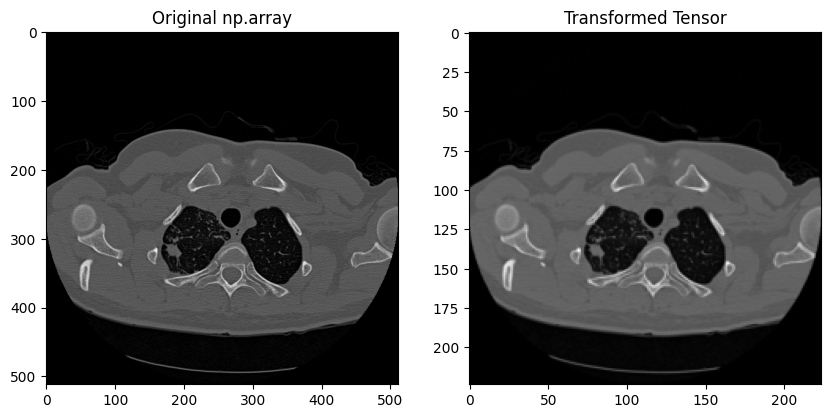

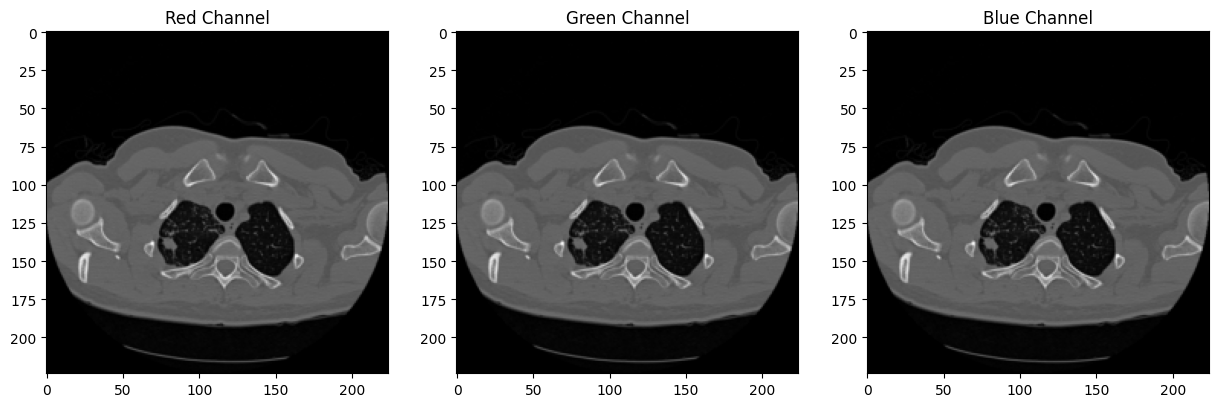

In [39]:
tensorVSnp(train_dataset)

As we can see, the transformation was successful and maintains relative data integrity, but some details were lost. This is due to the resize of (224,224) for ResNet compatibility.

Copying data to create the illusion of RGB for the ResNet input data is not destructive, as the nature of the transformation should not cause any blurriness. It does not apply any smoothing or averaging; it only replicates the grayscale data across the RGB channels. Since the pixel values remain the same across all channels, the image quality is not affected, and the image is not blurred. This is demonstrated in the separate plot of each color channel above.

Therefore, the logical conclusion is that the blurring found in the plot simply portrays the result of normalizing and resizing data, and does not represent data corruption.

```py
# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
```

In [46]:
def trainResNet(train_dataset, num_epochs=40, batch_size=32, lr=0.001):
    # New ResNet instance
    resnet18 = models.resnet18(pretrained=True)

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("Using",device)

    # Generate data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()  # Loss function 
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        resnet18.train()
        running_loss = 0.0
        
        # Iterates over each image in dataset
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    return resnet18

In [ ]:
resnet_hrct = trainResNet(train_dataset)

Finally, I'll perform a very simple accuracy test as an initial benchmark:

In [131]:
resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 37.54%


As expected, accuracy for 5 epochs was extremely low (37,54%). The next step is to evaluate accuracy on specific classes, since cases where fibrosis is present are drastically scarce, and are very likely to be hindering general performance:

In [134]:
# Counters for each class
correct_class_0, total_class_0 = 0, 0
correct_class_1, total_class_1 = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct for general accuracy
        total += labels.size(0)

        # Class-specific accuracy
        for label, pred in zip(labels, predicted):
            if label == 0:
                total_class_0 += 1
                if pred == label:
                    correct_class_0 += 1
            elif label == 1:
                total_class_1 += 1
                if pred == label:
                    correct_class_1 += 1

# Class-specific accuracy
accuracy_class_0 = 100 * correct_class_0 / total_class_0 if total_class_0 > 0 else 0
accuracy_class_1 = 100 * correct_class_1 / total_class_1 if total_class_1 > 0 else 0

print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")


Accuracy for Class 0: 37.12%  (111 in 299)
Accuracy for Class 1: 100.00%  (2 in 2)


At first, these values might seem incorrect. How is it possible that every fibrosis example was correct, even though there were many more training examples where there was no fibrosis?

The answer is simple: "0" classification does not mean the lung is healthy. Because ILD manifests itsef in various forms, it is likely that the model had issues identifying common patterns between:

 - a healthy lung
 - emphysema
 - ground_glass
 - micronodules
 - consolidation
 - bronchial_wall_thickening
 - reticulation
 - macronodules
 - cysts
 - peripheral_micronodules
 - bronchiectasis
 - air_trapping
 - early_fibrosis
 - increased_attenuation
 - tuberculosis
 - pcp

, as they were all paired into "0" classification.

The large variety of possible lung patterns may have caused the ResNet to focus on learning residual functions for the presence of unusual structures, **rather than the absence of structures**. 

Additionally, the fact that there were very few slices with fibrosis may have actaully helped the ResNet specify patterns, especially if their representation was strong and quite different from most of the manifestations represented above.

## Conclusions (1st run)

Since non-binary classification is not the goal of the project/internship, I must think of ways to mitigate this issue.

## Custom Test Split

The next expected performance analysis will be done on a custom test split, created by the script in `2 - testSplit`. 

In [23]:
train_df, test_df = pd.read_csv(r"../2 - testSplit\train_dataframe.csv"), pd.read_csv(r"../2 - testSplit\test_dataframe.csv")

In [24]:
def addNpy(df, i):
    if ".npy" not in df["SliceID"].iloc[i]: df["SliceID"] = df["SliceID"].apply(lambda x: x+".npy")
    return df

In [25]:
# Add .npy to ids
i_train, i_test = random.choice(range(len(train_df))), random.choice(range(len(test_df)))

train_df = addNpy(train_df, i_train)
test_df = addNpy(test_df, i_test)

train_df.to_csv("custom_train_dataframe.csv", index=False)
test_df.to_csv("custom_test_dataframe.csv", index=False)

In [26]:
# Paths
img_dir = r'D:\Rafa\A1Uni\2semestre\Estágio\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"custom_train_dataframe.csv"
annotations_file_test = r"custom_test_dataframe.csv"


# Transformations 
transform = transforms.Compose([
    # shear, translate, rotate, random(gauss_noise, gauss_blur)
    # possível resize (fibrose pode não precisar de 512)
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)

In [27]:
# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
criterion = nn.CrossEntropyLoss()  # Loss function 
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    resnet18.train()
    running_loss = 0.0
    
    for images, labels in tqdm((train_loader), desc = "Training..."):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1


Training...:   1%|▏         | 1/77 [00:15<19:25, 15.33s/it]


KeyboardInterrupt: 

In [55]:
# Counters for each class
correct, total = 0, 0
correct_class_0, total_class_0 = 0, 0
correct_class_1, total_class_1 = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct for general accuracy
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

        # Class-specific accuracy
        for label, pred in zip(labels, predicted):
            if label == 0:
                total_class_0 += 1
                if pred == label:
                    correct_class_0 += 1
            elif label == 1:
                total_class_1 += 1
                if pred == label:
                    correct_class_1 += 1

In [58]:
# Weights == 1 - proportions
weight_0, weight_1 = 1 - (total_class_0 / total), 1 - (total_class_1 / total) 

# Calculating accuracies
accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
accuracy = 100 * (correct / total)
accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
weighted_accuracy = 100 * (((correct_class_0*weight_0) + (correct_class_1*weight_1)) / total)

print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Accuracy (Combination of 0 and 1): {accuracy2:.2f}%")
print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

Accuracy for Class 0: 97.34%  (549 in 564)
Accuracy for Class 1: 26.09%  (18 in 69)
Test Accuracy: 89.57%
Test Accuracy (Combination of 0 and 1): 89.57%
Weighted Accuracy: 11.99%


## Conclusion (2nd run)

### 1 epoch!!!

Opposite to the previously obtained results: new test split (roughly 80-20 with same data proportion) portrays excellent Class 0 classification and very bad performance in Class 1 classification.

## Custom test split and augmentations

The initial idea consisted of creating new slice files by applying the transformations mentioned in `1 - dataPreprocessing`, with guaranteed effect. However, after consultation with advisor, the new process consists of applying successive transofrmations with some degree of probability of non-application, as well as introudction of a new augmantation technique (Gaussian Blur). 

These methods should improve overall generalization.

In [41]:
# Paths
img_dir = r'D:\Rafa\A1Uni\2semestre\Estágio\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"custom_train_dataframe.csv"
annotations_file_test = r"custom_test_dataframe.csv"

# Transformations 
transform = transforms.Compose([
    # shear, translate, rotate, random(gauss_noise, gauss_blur)
    # possível resize (fibrose pode não precisar de 512)
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Rotate
    A.Rotate(limit=(-350,30), p=1),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=1),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=1)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform, albumentations=augment, gauss=gauss)

SliceID at index 1758: 65__CT-7444-0007.npy
(224, 224, 3)


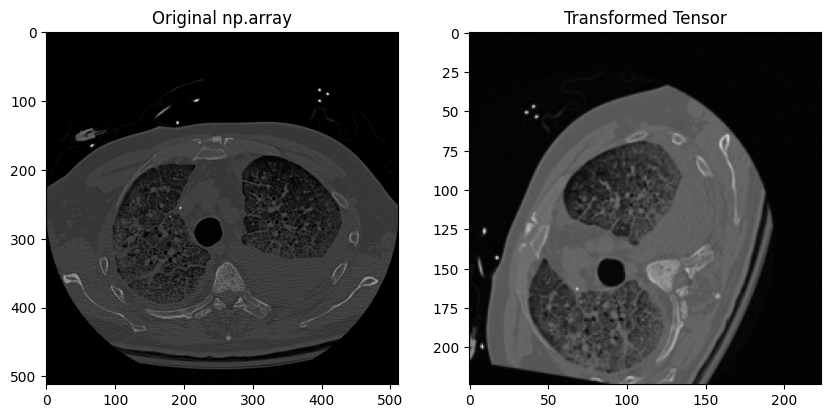

In [42]:
tensorVSnp(train_dataset, False)

In [43]:
# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
criterion = nn.CrossEntropyLoss()  # Loss function 
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    resnet18.train()
    running_loss = 0.0
    
    for images, labels in tqdm((train_loader), desc = "Training..."):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1


Training...: 100%|██████████| 77/77 [09:20<00:00,  7.28s/it]

Epoch [1/1], Loss: 0.3027


In [48]:
# Counters for each class
correct, total = 0, 0
correct_class_0, total_class_0 = 0, 0
correct_class_1, total_class_1 = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct for general accuracy
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

        # Class-specific accuracy
        for label, pred in zip(labels, predicted):
            if label == 0:
                total_class_0 += 1
                if pred == label:
                    correct_class_0 += 1
            elif label == 1:
                total_class_1 += 1
                if pred == label:
                    correct_class_1 += 1

In [49]:
# Weights == 1 - proportions
weight_0, weight_1 = 1 - (total_class_0 / total), 1 - (total_class_1 / total) 

# Calculating accuracies
accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
accuracy = 100 * (correct / total)
accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
weighted_accuracy = 100 * (((correct_class_0*weight_0) + (correct_class_1*weight_1)) / total)

print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Accuracy (Combination of 0 and 1): {accuracy2:.2f}%")
print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

Accuracy for Class 0: 99.82%  (563 in 564)
Accuracy for Class 1: 0.00%  (0 in 69)
Test Accuracy: 88.94%
Test Accuracy (Combination of 0 and 1): 88.94%
Weighted Accuracy: 9.70%
